## Image Classification
Image Classification using the Cats and Dog data from Kaggle

Importing the needed libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Section 1) Fetch of the Kaggle Cats vs Dogs dataset (5%)

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   153M      0  0:00:05  0:00:05 --:--:--  156M


In [3]:
#kagglecatsanddogs_3367a = %pwd
#from zipfile import ZipFile
#with ZipFile('kagglecatsanddogs_3367a.zip', 'r') as zf:
    #zf.extractall('kagglecatsanddogs_3367a/')

!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images")


Deleted 1590 images


## Generate a `Dataset`

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".

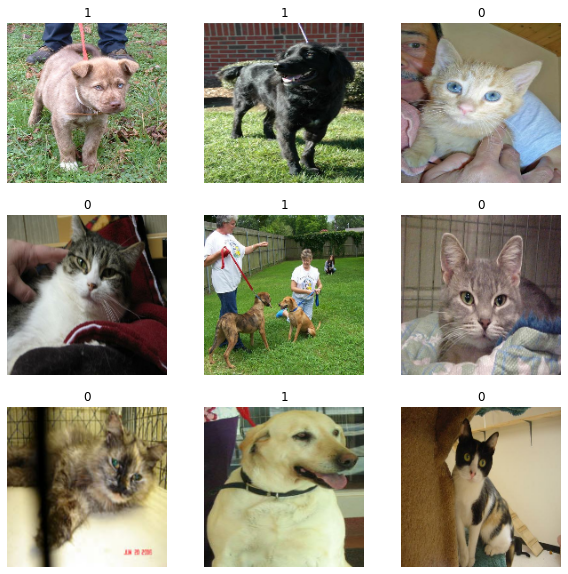

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When image dataset is small, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Visualizing what the augmented samples looks like, by applying 'data_augmentation' repeatedly to the first image in the dataset:

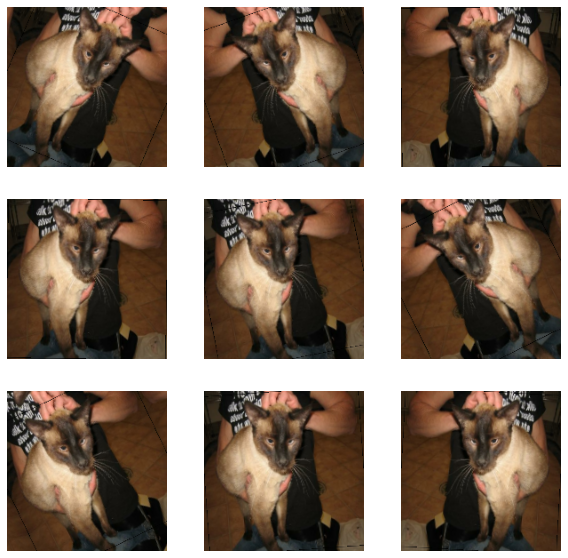

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

- Starting the model with the 'data_augmentation' preprocessor, followed by a 'Rescaling' layer.
- Include a 'Dropout' layer before the final classification layer.


In [11]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

Creating a variable to hold the model that is to be trained with 25 epochs

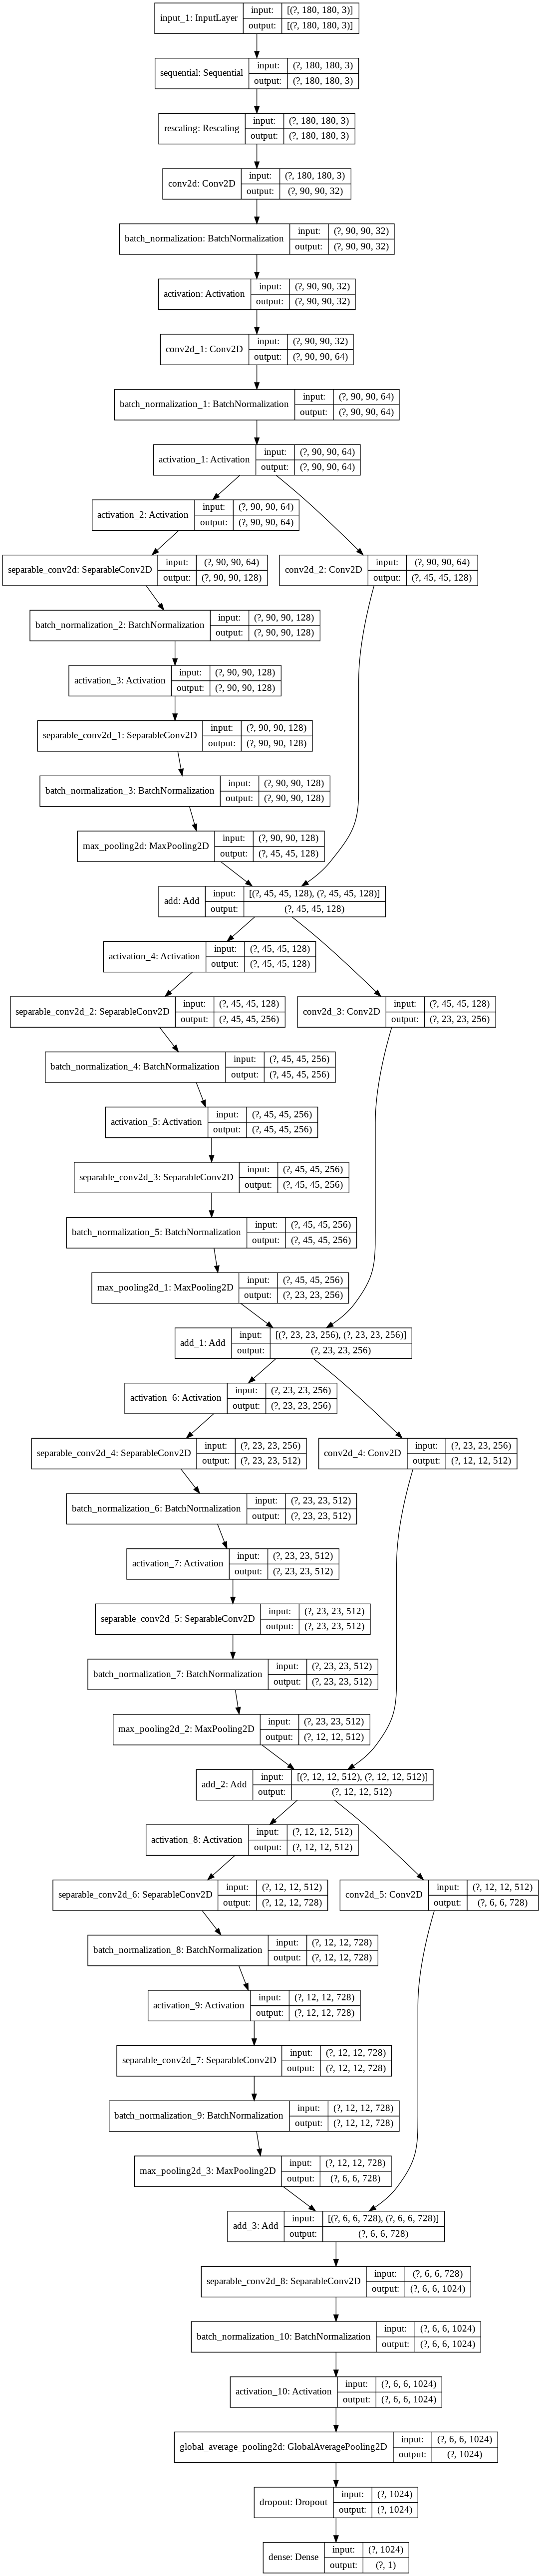

In [12]:
model_25epoch = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model_25epoch, show_shapes=True)

Creating a variable to hold the model that is to be trained with 50 epochs

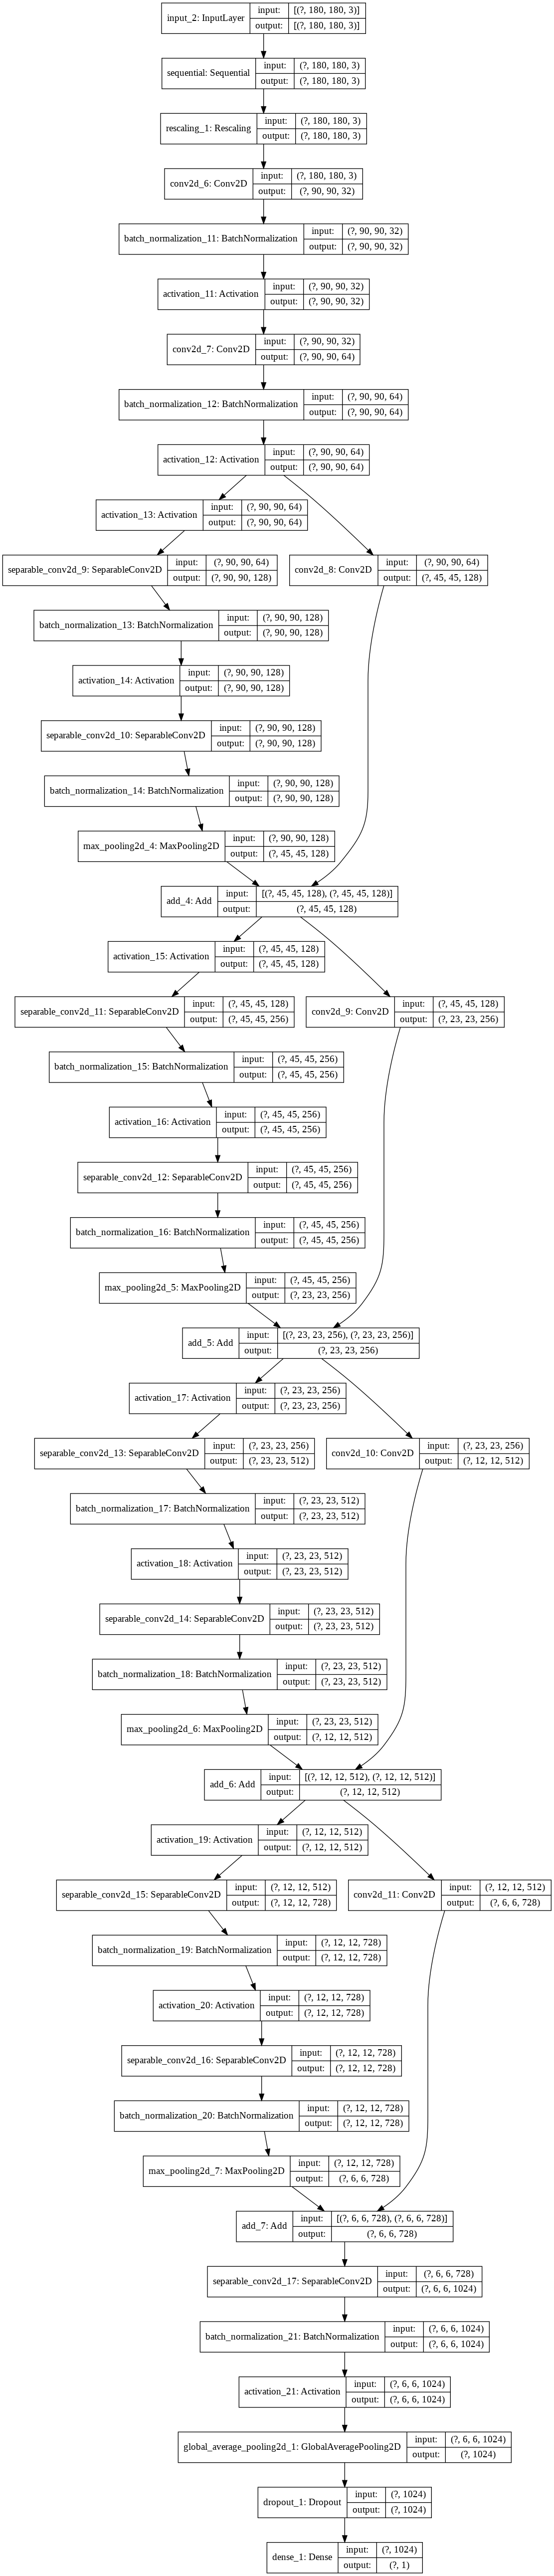

In [13]:
model_50epoch = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model_50epoch, show_shapes=True)

Section 3) Calculation of the accuracy of the model with 25 epochs and then 50 epochs

## Train Model

In [14]:
# 25 epoch
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model_25epoch.compile(optimizer=keras.optimizers.Adam(1e-3),loss="binary_crossentropy", metrics=["accuracy"],)
model_25epoch.fit(train_ds, epochs=25, callbacks=callbacks, validation_data=val_ds,)


Epoch 1/25
586/586 [==============================] - 160s 274ms/step - loss: 0.6216 - accuracy: 0.6696 - val_loss: 0.6964 - val_accuracy: 0.6290
Epoch 2/25
586/586 [==============================] - 159s 272ms/step - loss: 0.4749 - accuracy: 0.7762 - val_loss: 0.7657 - val_accuracy: 0.6839
Epoch 3/25
586/586 [==============================] - 159s 271ms/step - loss: 0.3908 - accuracy: 0.8252 - val_loss: 0.3689 - val_accuracy: 0.8332
Epoch 4/25
586/586 [==============================] - 159s 271ms/step - loss: 0.3258 - accuracy: 0.8609 - val_loss: 0.2851 - val_accuracy: 0.8853
Epoch 5/25
586/586 [==============================] - 159s 271ms/step - loss: 0.2719 - accuracy: 0.8856 - val_loss: 0.2319 - val_accuracy: 0.9041
Epoch 6/25
586/586 [==============================] - 159s 271ms/step - loss: 0.2270 - accuracy: 0.9052 - val_loss: 0.2947 - val_accuracy: 0.8891
Epoch 7/25
586/586 [==============================] - 159s 271ms/step - loss: 0.2107 - accuracy: 0.9116 - val_loss: 0.1990 -

In [15]:
# 50 epoch
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model_50epoch.compile(optimizer=keras.optimizers.Adam(1e-3),loss="binary_crossentropy", metrics=["accuracy"],)
model_50epoch.fit(train_ds, epochs=50, callbacks=callbacks, validation_data=val_ds,)

Epoch 1/50
586/586 [==============================] - 157s 269ms/step - loss: 0.5915 - accuracy: 0.6886 - val_loss: 1.2660 - val_accuracy: 0.5036
Epoch 2/50
586/586 [==============================] - 157s 268ms/step - loss: 0.4320 - accuracy: 0.7998 - val_loss: 0.4217 - val_accuracy: 0.8080
Epoch 3/50
586/586 [==============================] - 158s 269ms/step - loss: 0.3568 - accuracy: 0.8441 - val_loss: 0.4248 - val_accuracy: 0.7994
Epoch 4/50
586/586 [==============================] - 157s 268ms/step - loss: 0.2977 - accuracy: 0.8723 - val_loss: 0.2864 - val_accuracy: 0.8842
Epoch 5/50
586/586 [==============================] - 157s 269ms/step - loss: 0.2513 - accuracy: 0.8934 - val_loss: 0.2457 - val_accuracy: 0.8894
Epoch 6/50
586/586 [==============================] - 157s 268ms/step - loss: 0.2217 - accuracy: 0.9060 - val_loss: 0.3329 - val_accuracy: 0.8586
Epoch 7/50
586/586 [==============================] - 157s 267ms/step - loss: 0.1908 - accuracy: 0.9215 - val_loss: 0.5860 -

Mount the Google drive to save the trained model on drive

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Save the trained model on drive

In [18]:
model_25epoch.save("/content/gdrive/My Drive/Arbooj_Week4_Model_25.h5")
model_50epoch.save("/content/gdrive/My Drive/Arbooj_Week4_Model_50.h5")

The model accuracy is calculated below.

## Run inference on new data

The data augmentation and dropout are inactive at inference time.

In [19]:
img = keras.preprocessing.image.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_25epoch.predict(img_array)
score = predictions[0]
print(f'This image is {100 * (1 - predictions[0])} percent cat and {100 * predictions[0]} percent dog.')


This image is [67.54348] percent cat and [32.456524] percent dog.


Following are the functions to download the image from an url and classify it by passig it to the model

In [28]:
import requests
import matplotlib.image as mpimg
import glob
from urllib.parse import urlparse
from os.path import splitext
import random 


def get_ext(url):
    """Return the filename extension from url, or ''."""
    parsed = urlparse(url)
    root, ext = splitext(parsed.path)
    if ext:
        return ext
    else:
        return '.jpg'

def get_latest_file(path):
    # This function is created to get the latest file from the given path
    list_of_files = glob.iglob(path) 
    if not list_of_files:                
        return None                      
    latest_file = max(list_of_files, key=os.path.getctime)
    _, filename = os.path.split(latest_file)
    return filename

def download_image(url):
    # This function is created to download the image from the url
    response = requests.get(url)
    fileext = get_ext(url)
    fileName = "Image"+str(random.randint(1,1000))+fileext
    with open(fileName,"wb") as file:
        file.write(response.content)
        
    print('\nThe image from the entered URL is:\n')
    imagetest = get_latest_file(os.getcwd()+'/*')
    img = mpimg.imread(imagetest)
    plt.figure(figsize=(8, 8))
    imgplot = plt.imshow(img)
    plt.axis("off")

def classify_image(model_local):
    latestImage = get_latest_file(os.getcwd()+'/*')
    img = keras.preprocessing.image.load_img(latestImage, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model_local.predict(img_array)
    score = predictions[0]
    print(f'This image is {(100 * (1 - predictions[0]))[0]:^2f} % cat and {(100 * predictions[0])[0]:^2f} % dog.')
    


Get the image url from user and download the data on local space

Enter the image url: https://ichef.bbci.co.uk/news/1024/cpsprodpb/151AB/production/_111434468_gettyimages-1143489763.jpg

The image from the entered URL is:



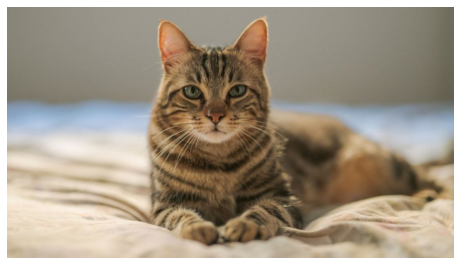

In [42]:
imageTestingURL = input('Enter the image url: ').strip()
download_image(imageTestingURL)

Show from the Jupyter notebok the file in your hard drive

In [43]:
print(os.listdir(os.getcwd()))
latestTestImage = get_latest_file(os.getcwd()+'/*')
print(f'As seen the downloaded image from the url is saved as {latestTestImage}')

['.config', 'save_at_32.h5', 'save_at_27.h5', 'save_at_2.h5', 'model.png', 'save_at_33.h5', 'save_at_20.h5', 'save_at_30.h5', 'save_at_5.h5', 'save_at_24.h5', 'save_at_42.h5', 'save_at_23.h5', 'Image927.png', 'save_at_9.h5', 'PetImages', 'save_at_7.h5', 'save_at_47.h5', 'Image482.jpg', 'Image454.jpg', 'save_at_44.h5', 'save_at_15.h5', 'save_at_18.h5', 'save_at_29.h5', 'Image280.jpg', 'save_at_37.h5', 'gdrive', 'save_at_21.h5', 'save_at_8.h5', 'save_at_39.h5', 'save_at_38.h5', 'save_at_13.h5', 'save_at_49.h5', 'save_at_48.h5', 'save_at_50.h5', 'save_at_3.h5', 'save_at_46.h5', 'save_at_25.h5', 'save_at_35.h5', 'save_at_34.h5', 'readme[1].txt', 'save_at_14.h5', 'save_at_41.h5', '_111434468_gettyimages-1143489763.jpg', 'Image732.jpg', 'save_at_17.h5', 'save_at_16.h5', 'Image289.png', 'MSR-LA - 3467.docx', 'save_at_31.h5', 'save_at_12.h5', 'save_at_28.h5', 'save_at_11.h5', 'save_at_6.h5', 'save_at_45.h5', 'save_at_22.h5', 'save_at_1.h5', 'save_at_40.h5', 'save_at_19.h5', 'Image779.jpg', 'sa

In [44]:
#Load the model that you want to test 
#Here, the model is saved on Google Drive so the path provided is of Google drive

loadedModel50 = keras.models.load_model("/content/gdrive/My Drive/Arbooj_Week4_Model_50.h5")
loadedModel25 = keras.models.load_model("/content/gdrive/My Drive/Arbooj_Week4_Model_25.h5")


In [45]:
classify_image(loadedModel50)

This image is 100.000000 % cat and 0.000000 % dog.


# TESTING


TEST 1:
Enter the image url: https://pngimg.com/uploads/dog/dog_PNG50348.png

The image from the entered URL is:

This image is 0.000644 % cat and 99.999359 % dog.

TEST 2:
Enter the image url: https://i.kym-cdn.com/photos/images/facebook/000/184/265/70b.png

The image from the entered URL is:

This image is 100.000000 % cat and 0.000000 % dog.

TEST 3:
Enter the image url: https://cdn.images.express.co.uk/img/dynamic/128/590x/Cat-631987.jpg

The image from the entered URL is:

This image is 99.999985 % cat and 0.000011 % dog.

TEST 4:
Enter the image url: https://ewscripps.brightspotcdn.com/dims4/default/cf2e1b3/2147483647/strip/true/crop/558x314+0+1/resize/1280x720!/quality/90/?url=http%3A%2F%2Fewscripps-brightspot.s3.amazonaws.com%2F70%2Fa3%2F649e1afc45269d09de8501f94856%2Flost-cat.png

The image from the entered URL is:

This image is 99.999969 % cat and 0.000029 % dog.

TEST 5:
Enter the image url: https://images.unsplash.com/photo-1575859431774-2e57ed632664?ixlib=rb-1.2.1&auto=f

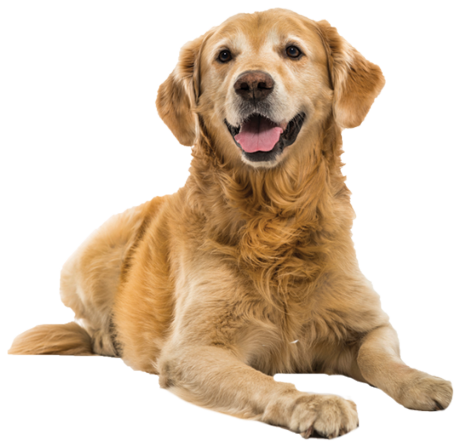

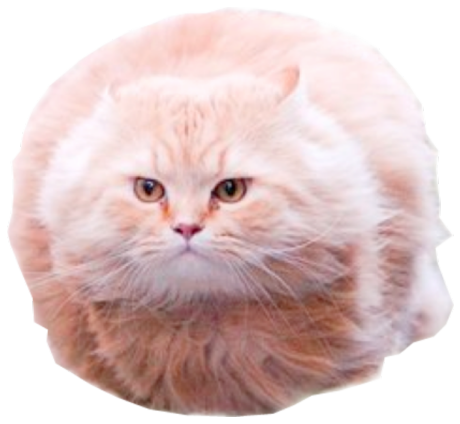

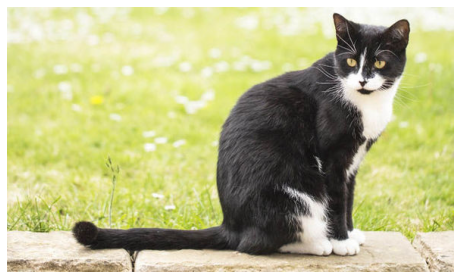

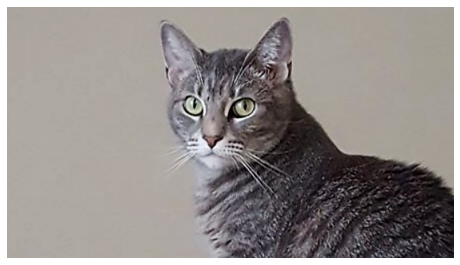

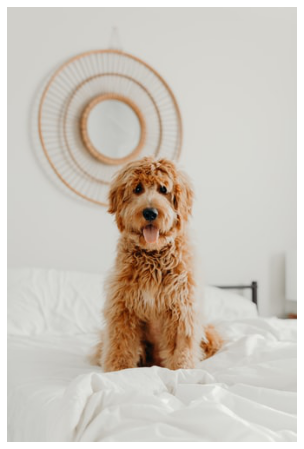

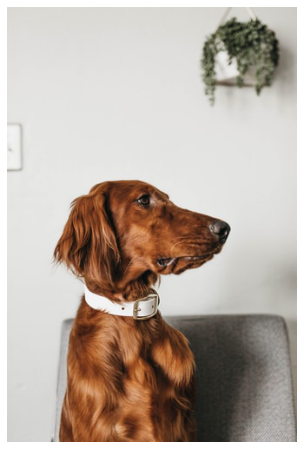

In [47]:
for i in range(6):
    print(f'\nTEST {i+1}:')
    imageTestingURL = input('Enter the image url: ').strip()
    download_image(imageTestingURL)
    classify_image(loadedModel)

Calculating the accuracy of the trained model using the training data

In [46]:
loss25, acc25 = loadedModel25.evaluate(train_ds)
print(f'\nEvaluating the model for 25 epoch:\nloss: {loss25} \n acc: {acc25}')

loss50, acc50 = loadedModel50.evaluate(train_ds)
print(f'\nEvaluating the model for 50 epoch:\n loss: {loss50} \n acc: {acc50}')

586/586 [==============================] - 37s 64ms/step - loss: 0.0883 - accuracy: 0.9639

Evaluating the model for 25 epoch:
loss: 0.08833599090576172 
 acc: 0.9639043211936951
586/586 [==============================] - 37s 63ms/step - loss: 0.0508 - accuracy: 0.9809

Evaluating the model for 50 epoch:
 loss: 0.0507650226354599 
 acc: 0.9808842539787292
